In [1]:
! pip install --quiet -U pdf2image pytesseract unstructured[all-docs] pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch langchain openai chromadb langchain-experimental
#! apt install poppler-utils
#! apt install tesseract-ocr

In [2]:
path = "LLaVA/"
filename = "LLaVA.pdf"

In [3]:
import os
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=os.path.join(path, filename),
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    extract_image_block_output_dir=path,
)

# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())


class Element(BaseModel):
    type: str
    text: Any


# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        categorized_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        categorized_elements.append(Element(type="text", text=str(element)))

# Tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# Text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name
2024-03-04 02:03:37.292246: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-04 02:03:37.326976: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-04 02:03:37.326998: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-04 02:03:37.328517: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register 

4
31


In [4]:
from langchain.prompts import ChatPromptTemplate
from langchain_openai.chat_models import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_community.callbacks.manager import get_openai_callback


# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatOpenAI(model="gpt-4-turbo-preview", temperature=0)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Apply to texts
texts = [i.text for i in text_elements]
with get_openai_callback() as callback:
    text_summaries = summarize_chain.batch(texts)
    print(callback, end="\n\n")

# Apply to tables
tables = [i.text for i in table_elements]
with get_openai_callback() as callback:
    table_summaries = summarize_chain.batch(tables)
    print(callback, end="\n\n")

Tokens Used: 28463
	Prompt Tokens: 21709
	Completion Tokens: 6754
Successful Requests: 31
Total Cost (USD): $0.41970999999999997

Tokens Used: 1938
	Prompt Tokens: 1037
	Completion Tokens: 901
Successful Requests: 4
Total Cost (USD): $0.0374



In [5]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage.in_memory import InMemoryStore
from langchain_community.vectorstores.chroma import Chroma
from langchain_core.documents import Document
from langchain_openai.embeddings import OpenAIEmbeddings

# The text_vectorstore to use to index the child chunks
text_vectorstore = Chroma(
    collection_name=str(path.replace("/", "_")) + "text_vectorstore",
    embedding_function=OpenAIEmbeddings(),
)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The text_retriever (empty to start)
text_retriever = MultiVectorRetriever(
    vectorstore=text_vectorstore,
    docstore=store,
    id_key=id_key,
    # search_kwargs={"k": 3},
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(text_summaries)]
text_retriever.vectorstore.add_documents(summary_texts)
text_retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=s, metadata={id_key: table_ids[i]}) for i, s in enumerate(table_summaries)]
text_retriever.vectorstore.add_documents(summary_tables)
text_retriever.docstore.mset(list(zip(table_ids, tables)))

In [6]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings


# Create chroma
image_vectorstore = Chroma(
    collection_name=str(path.replace("/", "_")) + "image_vectorstore",
    embedding_function=OpenCLIPEmbeddings(),
)

# Add images
# Get image URIs with .jpg extension only
image_uris = sorted([os.path.join(path, image_name) for image_name in os.listdir(path) if image_name.endswith(".jpg")])
image_vectorstore.add_images(uris=image_uris)

# Make retriever
image_retriever = image_vectorstore.as_retriever(
    # search_kwargs={"k": 3},
)

In [ ]:
text_retriever.get_relevant_documents("")

In [ ]:
image_retriever.get_relevant_documents("")

In [ ]:
from langchain.retrievers import EnsembleRetriever

ensemble_retriever = EnsembleRetriever(retrievers=[text_retriever, image_retriever], weights=[0.5, 0.5])
ensemble_retriever.get_relevant_documents("related work")

In [24]:
import base64
import io

from PIL import Image


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string.

    Args:
    base64_string (str): Base64 string of the original image.
    size (tuple): Desired size of the image as (width, height).

    Returns:
    str: Base64 string of the resized image.
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def is_base64(s):
    """Check if a string is Base64 encoded"""
    try:
        return base64.b64encode(base64.b64decode(s)) == s.encode()
    except Exception:
        return False


def split_image_text_types(docs):
    """Split numpy array images and texts"""
    images = []
    text = []
    for doc in docs:
        doc = doc.page_content  # Extract Document contents
        if is_base64(doc):
            # Resize image to avoid OAI server error
            images.append(resize_base64_image(doc, size=(250, 250)))  # base64 encoded str
        else:
            text.append(doc)
    return {"images": images, "texts": text}

In [25]:
from operator import itemgetter

from langchain_openai.chat_models import ChatOpenAI
from langchain_core.messages import HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import (
    RunnableLambda,
    RunnablePassthrough,
    RunnableParallel,
)


def prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"},
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "As a secretary, your task is to extract and interpret both textual and visual information from the document, leveraging the rich context provided. The content has been sourced based on specific keywords input by the user."
            "**If the document does not contain direct references or clear data relevant to the user's query, you must clearly state 'No sufficient reference available to provide an answer' and refrain from answering further.**"
            f"Keywords provided by the user: {data_dict['question']}\n\n"
            "Extracted content:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)

    return [HumanMessage(content=messages)]

In [26]:
model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=4096)

# RAG pipeline
chain = {
    "context": ensemble_retriever | RunnableLambda(split_image_text_types),
    "question": RunnablePassthrough(),
} | RunnableParallel(
    {
        "response": prompt_func | model | StrOutputParser(),
        "context": itemgetter("context"),
    }
)

In [27]:
from IPython.display import HTML


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))

In [28]:
from langchain_community.callbacks.manager import get_openai_callback


def displayRAG(question):
    print("###QUESTION###")
    print(question, end="\n\n")

    with get_openai_callback() as callback:
        response = chain.invoke(question)
        print(callback, end="\n\n")

    print("###ANSWER###")
    print(response["response"], end="\n\n")

    for i, image in enumerate(response["context"]["images"]):
        print(f"###IMAGE{i+1}###")
        plt_img_base64(image)

    for i, text in enumerate(response["context"]["texts"]):
        print(f"###TEXT{i+1}###")
        print(text, end="\n\n")

###QUESTION###
What is the performance of LLaVA across multiple image domains / subjects?

Tokens Used: 2544
	Prompt Tokens: 2147
	Completion Tokens: 397
Successful Requests: 1
Total Cost (USD): $0.03338

###ANSWER###
Based on the extracted content, LLaVA (Language and Vision Assistant) appears to be a multimodal model that has been evaluated across multiple image domains or subjects using benchmarks such as LLaVA-Bench (COCO) and LLaVA-Bench (In-the-Wild). The performance of LLaVA is reported to be significantly better than other models like BLIP-2 and OpenFlamingo, particularly in tasks that involve complex reasoning and detailed descriptions.

LLaVA-Bench (COCO) involved 30 images from the COCO-Val-2014 dataset with 90 questions generated to assess the model's alignment behavior and capabilities with consistent visual inputs. The results showed that instruction tuning improved the model's ability to follow user instructions by over 50 points, and adding detailed description and comp


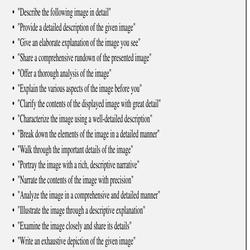

###IMAGE2###



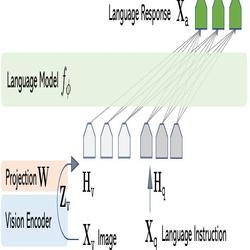

###IMAGE3###



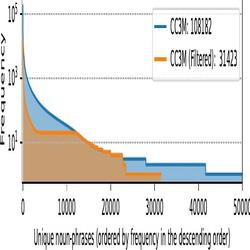

###IMAGE4###



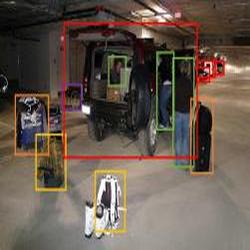

###TEXT1###
Table 5: Instruction-following capability comparison using relative scores on LLaVA-Bench (In-the- Wild). The results are reported in the format of mean ± std. For the first three rows, we report three inference runs. LLaVA performs significantly better than others. † For a given set of LLaVA decoding sequences, we evaluate by querying GPT-4 three times; GPT-4 gives a consistent evaluation.

models. We report relative scores w.r.t. the text-only GPT-4 model that uses the textural ground truth description as visual input. We create two benchmarks to evaluate the model’s performance.

LLaVA-Bench (COCO). We randomly select 30 images from COCO-Val-2014, and for each image, we generate three types of questions (conversation, detailed description, complex reasoning) using the proposed data generation pipeline in Sec. 3, totaling 90 questions. This benchmark studies the model’s alignment behavior and capabilities with consistent visual inputs. We vary the training datasets to stu

In [29]:
displayRAG("What is the performance of LLaVA across multiple image domains / subjects?")